In [1]:
import os, sys
sys.path.append("../src")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file, save_file

from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import vae_decode, vae_encode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.hv_train_network import collator_class, load_prompts
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.utils.bbox_utils import get_mask_from_bboxes, draw_bboxes, draw_bboxes_images, auto_scale_layout_data
from musubi_tuner.wan_generate_video import merge_lora_weights
from musubi_tuner.utils.preproc_utils import getres, get_text_preproc, prepare_control_inputs_for_entity, preproc_mask, postproc_imgs
from musubi_tuner.utils.preproc_utils import get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map
from musubi_tuner.utils.viz_utils import printable_metadata, return_total_visualization
# from musubi_tuner.utils.dwpose import DwposeDetector
from musubi_tuner.utils.keypalign_utils import search_facebbox_for_layout

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset

device = torch.device('cuda')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


model_path is /home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


In [2]:
# main_path = Path("/projects/bffz/ykwon4/ComfyUI/models")
main_path = Path("/lustre/fs1/home/yo564250/workspace/ComfyUI/models")
dit_path = "diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "text_encoders/clip_l.safetensors"
# image_encoder_path = "clip_vision/sigclip_vision_patch14_384.safetensors"

lora_path = '../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_3-step00001000.safetensors'
lora_multiplier = 0.8

model = load_packed_model(device, main_path / dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

if lora_path is not None:
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [lora_multiplier], 
            include_patterns=None, exclude_patterns=None, lycoris=None, save_merged_model=False
        ), 
    device, None)

vae = load_vae(str(main_path / vae_path), 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=str(main_path / text_encoder1_path)), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=str(main_path / text_encoder2_path)))
# feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=str(main_path / image_encoder_path)))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_3-step00001000.safetensors with multiplier 0.8
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:cre

In [3]:
vistory_dataset_path = Path('/groups/chenchen/patrick/ViStoryBench/dataset/ViStory')
story_num = '04'
shot_num = 2
max_scene_sentences = 3
max_characters = 1

vistory_dataset = StoryDataset(vistory_dataset_path)

story_shot, characters_shot = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ". " + ", ".join(story_shot['scene'].split(", ")[:max_scene_sentences]) + ". " + story_shot['script']
print(f"Prompt: {prompt}")

# author_output_dir = sorted(
#     list(vistory_dataset_path.glob(f"{story_num}/gen_layouts/*")), 
#     key=lambda x: datetime.strptime(x.stem, "%Y%m%d_%H%M%S")
# )[-1]
author_output_dir = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053/story_04-pages_1_4")
layout = parse_bodylayout(author_output_dir / "pose_layout.json")

rel_w, rel_h, panel_layout = layout[f'[PANEL-{shot_num}]']
width, height = getres(rel_w, rel_h, target_area=1280*720)
print(f"Size: ({width}, {height})")

auto_scaled_layout, metadata = auto_scale_layout_data(panel_layout)
print(metadata)

debug_dict = search_facebbox_for_layout(
    auto_scaled_layout, characters_shot, (width, height), 
    c_width=None, scale_c_by_bbox=False, scale_c=0.1)

for k,v in debug_dict.items():
    print(f"Entity {k+1}")
    print(f"\tControl Image Path: {v['control_image_path']}")
    print(f"\tControl Image Size: {v['control_image_size']}")
    print("\tAttn BBox: [" + ', '.join([f"{b:.3f}" for b in v['entity_bbox']]) + "]")
    print("\tFace BBox: [" + ', '.join([f"{b:.3f}" for b in v['face_bbox']]) + "]")

Prompt: Chinese Ancient Wuxia. Daytime, Mongolian grasslands, serene. Huang Rong sits on the grass, looking sorrowful as she confides in Guo Jing. Guo Jing stands nearby, his expression sympathetic as he listens attentively.
Size: (1008, 912)
{1: {'scale_factor': 1.1, 'direction': 'top-right', 'status': 'scaled_successfully', 'original_area': 0.273707, 'final_area': 0.33118547, 'score': 0.933221795}, 0: {'scale_factor': 0.8, 'direction': 'top-left', 'status': 'scaled_successfully', 'original_area': 0.28919, 'final_area': 0.18508160000000004, 'score': 0.7876224000000002}}
DWPose: Bbox 330.38ms
DWPose: Pose 216.65ms on 1 people

DWPose: Bbox 3600.39ms
DWPose: Pose 2773.59ms on 1 people

Entity 1
	Control Image Path: /groups/chenchen/patrick/ViStoryBench/dataset/ViStory/04/image/Guo Jing/00.jpg
	Control Image Size: (288, 220)
	Attn BBox: [0.077, 0.367, 0.459, 0.851]
	Face BBox: [0.207, 0.376, 0.378, 0.521]
Entity 2
	Control Image Path: /groups/chenchen/patrick/ViStoryBench/dataset/ViStory

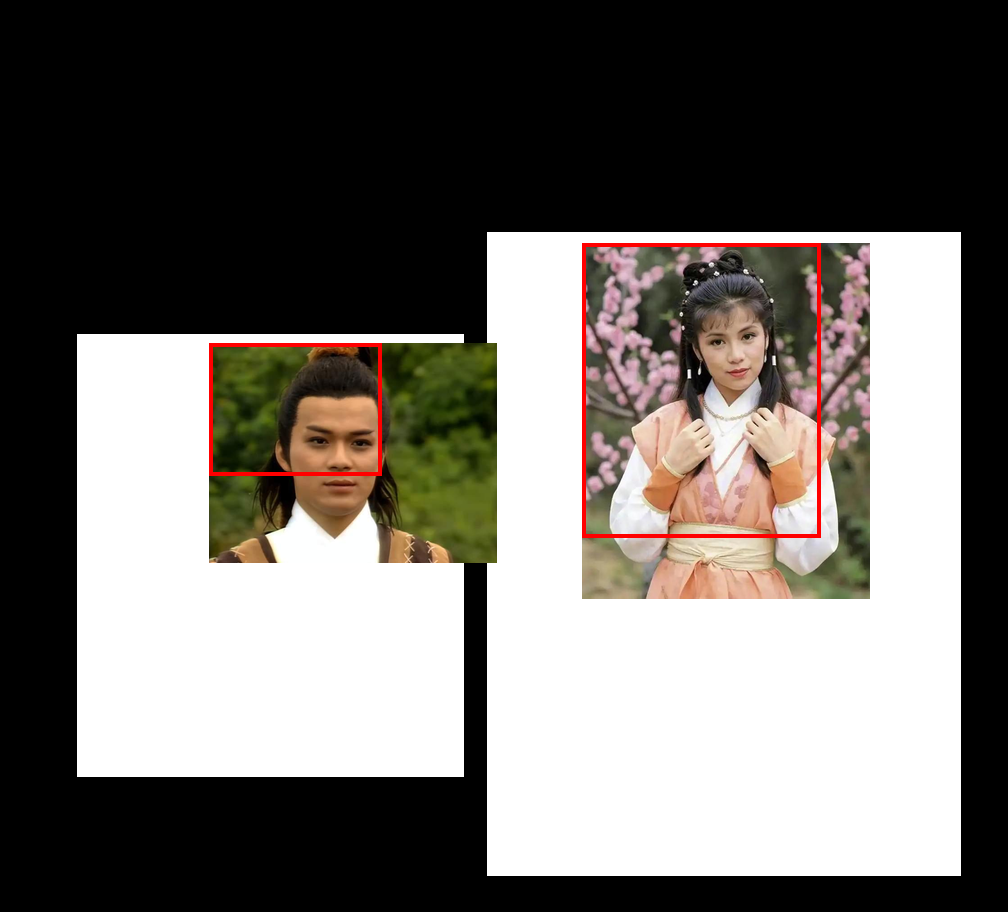

In [12]:
max_characters=2
if len(debug_dict) == 0:
    control_image_paths = []
    control_image_sizes = []
    entity_bboxes = []
    face_bboxes = []
else:
    control_image_paths = [debug_dict[i]['control_image_path'] for i in range(max_characters)]
    control_image_sizes = [debug_dict[i]['control_image_size'] for i in range(max_characters)]
    entity_bboxes = [debug_dict[i]['entity_bbox'] for i in range(max_characters)]
    face_bboxes = [debug_dict[i]['face_bbox'] for i in range(max_characters)]

entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)

debug_mask = Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")
debug_mask = draw_bboxes_images(debug_mask, face_bboxes, control_image_paths, cimg_sizes=control_image_sizes)
debug_mask = draw_bboxes(debug_mask, face_bboxes, width=4)
debug_mask

In [ ]:
text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    control_image_sizes,
    face_entity_bboxes=face_bboxes,
    control_indices=[0], latent_indices=[3], 
    adjust_custom_wh=False, 
    mode="provided_face_bbox",
    # mode="provided_size_mid_x",
    use_rembg=True, print_res=False)
control_kwargs['clean_latent_indices'] = control_kwargs['clean_latent_indices'][0]
# control_kwargs['clean_latent_bboxes'] = control_kwargs['clean_latent_bboxes'][0]

num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 364289299
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    # 'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': num_inference_steps, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img

In [ ]:
result_img = draw_bboxes(result_img, entity_bboxes)
result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))

meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(f'vistorybench_{story_num}_{shot_num}', meta_str, 
                                        np.asarray(result_img), 
                                        attn_mask, control_nps[0], np.asarray(debug_mask), 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img

In [ ]:
# from collections import defaultdict
# latents = torch.randn(
#     (1, 16, (1 + 3) // 4, height // 8, width // 8), 
#     generator=generator
# ).to(device=device, dtype=torch.bfloat16)
# hidden_order_dict = defaultdict(list)

# with torch.no_grad():
#     # hidden_states, rope_freqs, hidden_order_dict = model.process_input_hidden_states(
#     #     hidden_states,
#     #     hidden_order_dict,
#     #     **control_kwargs
#     # )
#     hidden_states = model.x_embedder.proj(latents)
#     B, C, T, H, W = hidden_states.shape
#     hidden_states = hidden_states.flatten(2).transpose(1, 2)
#     hidden_WH = hidden_states.shape[1]

#     rope_freqs = model.rope(frame_indices=control_kwargs['latent_indices'], 
#                             height=H, width=W, device=hidden_states.device)
#     rope_freqs = rope_freqs.flatten(2).transpose(1, 2)

#     processed_clean_latents, clean_latent_rope_freqs = [], []
#     latent_counter = 0
#     for i, (clean_latent, clean_latent_index) in enumerate(zip(control_kwargs['clean_latents'], control_kwargs['clean_latent_indices'])):
#         clean_latent = model.clean_x_embedder.proj(clean_latent.to(hidden_states))
#         print(clean_latent)
#         _, _, _, clean_H, clean_W = clean_latent.shape
#         clean_latent_bbox = control_kwargs['clean_latent_bboxes'][:,i]
#         print(clean_latent_bbox)

#         clean_latent_rope_freq = []
#         for b in range(B):
#             cb = [
#                 int(clean_latent_bbox[b,0]*W), int(clean_latent_bbox[b,1]*H), 
#                 int(clean_latent_bbox[b,2]*W), int(clean_latent_bbox[b,3]*H)
#             ]
#             print(cb)
#             cb_rope_freq = model.rope(
#                 frame_indices=clean_latent_index[[b]], 
#                 height=cb[3], width=cb[2],
#                 start_height=cb[1], start_width=cb[0],
#                 step_H=(cb[3] - cb[1]) / clean_H,
#                 step_W=(cb[2] - cb[0]) / clean_W,
#                 device=clean_latent.device)
#             print(cb_rope_freq)
#             # logger.info(f"Clean Latent Rope Freq Shape: {cb_rope_freq.shape}")
#             clean_latent_rope_freq.append(cb_rope_freq)
#         clean_latent_rope_freq = torch.cat(clean_latent_rope_freq, dim=0)

#         clean_latent = clean_latent.flatten(2).transpose(1, 2)
#         clean_latent_rope_freq = clean_latent_rope_freq.flatten(2).transpose(1, 2)
#         hidden_order_dict['rope_freqs'].append(clean_latent_rope_freq)
        
#         processed_clean_latents.append(clean_latent)
#         clean_latent_rope_freqs.append(clean_latent_rope_freq)
#         clean_WH = clean_latent.shape[1]
#         hidden_order_dict['clean_latents'].append((latent_counter, latent_counter+clean_WH))
#         latent_counter += clean_WH

#     processed_clean_latents = torch.cat(processed_clean_latents, dim=1)
#     clean_latent_rope_freqs = torch.cat(clean_latent_rope_freqs, dim=1)

#     hidden_states = torch.cat([processed_clean_latents, hidden_states], dim=1)
#     rope_freqs = torch.cat([clean_latent_rope_freqs, rope_freqs], dim=1)
# print(hidden_states)
# print(rope_freqs)
